<a href="https://colab.research.google.com/github/vincefav/stable-diffusion-lite/blob/main/Stable_Diffusion_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stable Diffusion Lite by [FutureArt](https://twitter.com/future__art) and [Pharmapsychotic](https://twitter.com/pharmapsychotic)

v 1.1, last updated 8/23/22

Generate images with CompVis/Stability [Stable Diffusion](https://github.com/CompVis/stable-diffusion) with bonus [KLMS sampling](https://github.com/crowsonkb/k-diffusion.git) from [@RiversHaveWings](https://twitter.com/RiversHaveWings).

This notebook is a pretty faithful copy of [pharmapsychotic's Stable Diffusion notebook](https://colab.research.google.com/github/pharmapsychotic/ai-notebooks/blob/main/pharmapsychotic_Stable_Diffusion.ipynb). I just simplified some settings, wrote some instructions, and added the ability to queue up multiple prompts. If you want more control over your settings, such as selecting what sampler to use, then I suggest using the original notebook.

I plan to make improvements to this notebook. Please [follow me on Twitter](https://twitter.com/future__art) or [watch my github](https://github.com/vincefav/stable-diffusion-lite) to get updates.

### How to download the model

- Visit https://huggingface.co/CompVis/stable-diffusion-v-1-4-original and agree to the terms and conditions.
- Click the **Files and versions** tab
- Click **stable-diffusion-v-1-4-original**
- Click the **download** link where it says *This file is stored with Git LFS . It is too big to display, but you can still download it.*
- If you have [Google Drive for desktop](https://www.google.com/drive/download/) (highly recommended), you can save it directly to your **AI/models** directory.
  - Otherwise, download it and re-upload it to your [Google Drive](https://drive.google.com) in the **AI/models** directory. (This is risky, as the upload may time out.)

In [ ]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9401321f-da0b-d717-c86d-849244ef1882)


# 1. Setup

In [ ]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/Stable Diffusion/images_out"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Outputs will be saved to /content/gdrive/MyDrive/AI/Stable Diffusion/images_out


In [ ]:
#@title Installation
!pip install pytorch-lightning torch-fidelity
!pip install numpy omegaconf einops kornia pytorch-lightning
!pip install albumentations transformers
!pip install ftfy jsonmerge resize-right torchdiffeq tqdm

!git clone https://github.com/CompVis/stable-diffusion
%cd stable-diffusion/
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

import sys
sys.path.append(".")
sys.path.append("./CLIP")
sys.path.append('./taming-transformers')
sys.path.append('./k-diffusion')

!echo '' > ./k-diffusion/k_diffusion/__init__.py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'stable-diffusion'...
remote: Enumerating objects: 313, done.
remote: Total 313 (delta 0), reused 0 (delta 0), pack-reused 313
Receiving objects: 100% (313/313), 42.62 MiB | 50.92 MiB/s, done.
Resolving deltas: 100% (116/116), done.
/content/stable-diffusion/stable-diffusion
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 63.33 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 236, don

In [ ]:
#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt" #@param {type:"string"}

In [ ]:
#@title Define helper functions

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch.cuda.amp import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms
from k_diffusion.external import CompVisDenoiser


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'full' # 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
      
def load_img(path, w, h):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize((w, h), Image.LANCZOS)
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)

    if opt.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, opt.W, opt.H).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    t_enc = int(opt.strength * opt.ddim_steps)

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision == "autocast" else nullcontext

    images = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if init_latent != None:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,)
                        else:

                            if opt.sampler == 'klms':
                                print("Using KLMS sampling")
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                                model_wrap_cfg = CFGDenoiser(model_wrap)
                                x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0]
                                extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                                samples = sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                            else:
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                samples, _ = sampler.sample(S=opt.ddim_steps,
                                                                conditioning=c,
                                                                batch_size=opt.n_samples,
                                                                shape=shape,
                                                                verbose=False,
                                                                unconditional_guidance_scale=opt.scale,
                                                                unconditional_conditioning=uc,
                                                                eta=opt.ddim_eta,
                                                                x_T=start_code)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            images.append(Image.fromarray(x_sample.astype(np.uint8)))
                            filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx}) {opt.seed}.png")#####
                            print(f"Saving to {filepath}")
                            Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                            sample_idx += 1
    return images


Loading model from /content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.enco

# 2. Diffuse!

Used seed: 3021679588
Saved to: /content/gdrive/MyDrive/AI/StableDiffusion/vince


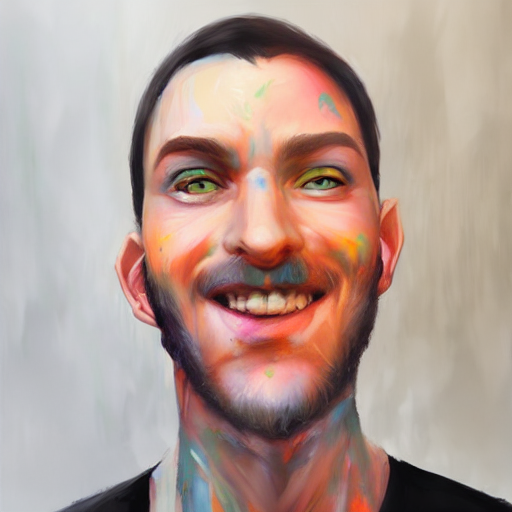

In [ ]:
#@title Image creation

#@markdown Files are saved as the batch name, followed by the batch number, followed by the image seed.

#@markdown `batch_name`: name for subfolder and filenames<br>
#@markdown `width` and `height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `number_of_images`: how many images you want to generate in this batch<br>
#@markdown `init_image_or_folder`: url or path to an image, or path to a folder to pick random images from<br>
#@markdown `init_strength`: from 0.0 to 1.0 how much the init image is used<br>

#@markdown 

batch_name = "vince" #@param {type:"string"}
prompt = "close-up portrait of an elven warrior. impasto oil on canvas, wet paint, by ross tran rossdraws, colorful" #@param {type:"string"}

#@markdown

# I hid some settings: sampler, ddim_eta, and seed. Add the @ after param to expose them again.
width = 512 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 10 #@param {type:"slider", min:0, max:20, step:0.5}
steps = 50 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 3 #@param {type:"integer"}
sampler = 'klms' # param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
seed = -1 # param {type:"integer"}
save_settings_file = False#@param{type:"boolean"}

#@markdown 

init_image_or_folder = "https://cdn.discordapp.com/attachments/980223192008380446/1011550253431918652/vf2_2.jpg" #@param {type:"string"}
init_strength = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}

#@markdown 


opt.init_img = init_image_or_folder
opt.ddim_steps = steps
opt.n_iter = 1
opt.n_samples = samples_per_batch
opt.outdir = os.path.join(outputs_path, batch_name)
opt.prompt = prompt
opt.sampler = sampler
opt.scale = guidance_scale
opt.seed = random.randint(0, 2**32) if seed == -1 else seed
opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
opt.W = width_height[0]
opt.H = width_height[1]

if opt.strength >= 1 or init_image_or_folder == None:
    opt.init_img = ""

if opt.init_img != None and opt.init_img != '':
    opt.sampler = 'ddim'

if opt.sampler != 'ddim':
    opt.ddim_eta = 0.0

# save settings
settings = {
    'ddim_eta': ddim_eta,
    'guidance_scale': guidance_scale,
    'init_image': init_image_or_folder,
    'init_strength': init_strength,
    'number_of_images': number_of_images,
    'prompt': prompt,
    'sampler': sampler,
    'samples_per_batch': samples_per_batch,
    'seed': opt.seed,
    'steps': steps,
    'width': opt.W,
    'height': opt.H,
}
os.makedirs(opt.outdir, exist_ok=True)
while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
    batch_idx += 1
if save_settings_file:
  with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
      json.dump(settings, f, ensure_ascii=False, indent=4)
with open(f"{opt.outdir}/prompt.txt", 'w') as f:
        f.write(prompt)
sample_idx = 0

for i in range(number_of_images):
    gc.collect()
    torch.cuda.empty_cache()

    images = generate(opt)

    clear_output(wait=True)
    print(f"Used seed: {opt.seed}")
    print(f"Saved to: {opt.outdir}")
    for image in images:
        display(image)

    opt.seed += 1


In [ ]:
# I like to add a "speed bump" so you can select "Run all" when you open a notebook.
# If you do, it'll stop here with an error
raise ValueError("Stopping here")

ValueError: ignored

---

# 3. Prompt Queuing

Use this section if you want to run multiple prompts and create several images.

In [ ]:
# Put each of your prompts on a new line

prompts = '''
a beautiful painting of a waterlily pond
a beautiful painting of a serene landscape
a beautiful still-life painting of flowers in a vase
'''

Used seed: 2919697853
Saved to: /content/gdrive/MyDrive/AI/Stable Diffusion/images_out/a beautiful stilllife painting of flowers in a vase


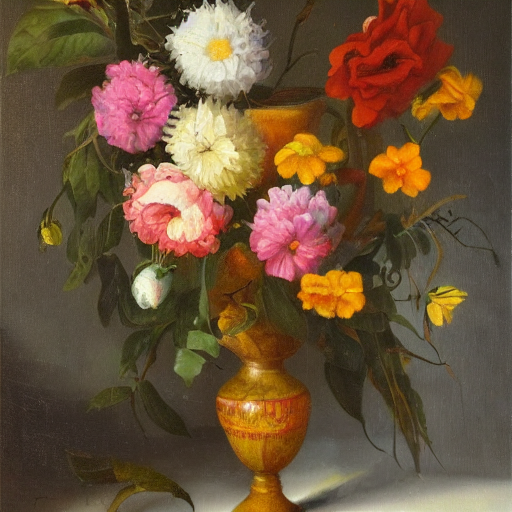

In [ ]:
#@title Image creation

#@markdown `batch_name`: name for subfolder and filenames<br>
#@markdown `width` and `height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `number_of_images`: how many images you want to generate in this batch<br>

#@markdown

import re

if type(prompts) is str:
  prompts = [i for i in prompts.split('\n') if i]

def clean_string(s):
    s = ''.join([c for c in s if (re.match('[a-zA-Z0-9 _]', c) or ord(c) > 127)]).strip()
    if len(s) > 200:
        return (s[:150]).strip()
    return s

width = 512 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 7.5 #@param {type:"slider", min:0, max:20, step:0.5}
steps = 50 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 10 #@param {type:"integer"}
sampler = 'klms' # param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
seed = -1 #@param {type:"integer"}

#@markdown

#@markdown Init image
init_image_or_folder = "" #@param {type:"string"}
init_strength = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}

save_settings_file = False#@param{type:"boolean"}

for prompt in prompts:
  batch_name = clean_string(prompt)
  opt.outdir = os.path.join(outputs_path, batch_name) 
  opt.init_img = init_image_or_folder
  opt.ddim_steps = steps
  opt.n_iter = 1
  opt.n_samples = samples_per_batch
  opt.prompt = prompt
  opt.sampler = sampler
  opt.scale = guidance_scale
  opt.seed = random.randint(0, 2**32) if seed == -1 else seed
  opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
  opt.W = width_height[0]
  opt.H = width_height[1]

  if opt.strength >= 1 or init_image_or_folder == None:
      opt.init_img = ""

  if opt.init_img != None and opt.init_img != '':
      opt.sampler = 'ddim'

  if opt.sampler != 'ddim':
      opt.ddim_eta = 0.0

  # save settings
  settings = {
      'ddim_eta': ddim_eta,
      'guidance_scale': guidance_scale,
      'init_image': init_image_or_folder,
      'init_strength': init_strength,
      'number_of_images': number_of_images,
      'prompt': prompt,
      'sampler': sampler,
      'samples_per_batch': samples_per_batch,
      'seed': opt.seed,
      'steps': steps,
      'width': opt.W,
      'height': opt.H,
  }
  os.makedirs(opt.outdir, exist_ok=True)
  while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
      batch_idx += 1
  if save_settings_file:
    with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
        json.dump(settings, f, ensure_ascii=False, indent=4)
  with open(f"{opt.outdir}/prompt.txt", 'w') as f:
        f.write(prompt)
  sample_idx = 0

  for i in range(number_of_images):
      gc.collect()
      torch.cuda.empty_cache()

      images = generate(opt)

      clear_output(wait=True)
      print(f"Used seed: {opt.seed}")
      print(f"Saved to: {opt.outdir}")
      for image in images:
          display(image)

      opt.seed += 1


# 4. Seed Mining

Use this section if you want to keep the same seed as you run it through different prompt variations. (The seed won't change in each successive run.)

In [ ]:
# Put each of your prompts on a new line. They should be similar with very slight tweaks.

prompts = '''
a beautiful still-life painting of flowers in a vase by claude monet
a beautiful still-life painting of flowers in a vase by vincent van gogh
a beautiful still-life painting of flowers in a vase by john singer sargent
'''

Used seed: 123456789
Saved to: /content/gdrive/MyDrive/AI/Stable Diffusion/images_out/flowers in a vase


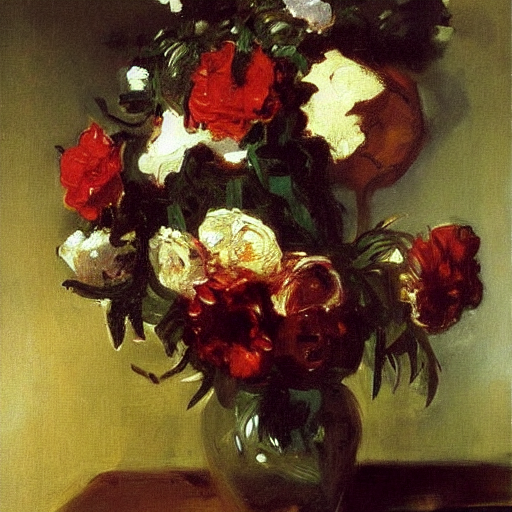

In [ ]:
#@title Image creation
#@markdown `batch_name`: the folder to which your images will save<br>
#@markdown `width` and `height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `number_of_images`: you probably only need 1 for seed mining<br>
#@markdown `save_settings_file`: I recommend keeping this on, so you can match your images to your prompts<br>


#@markdown

import re

if type(prompts) is str:
  prompts = [i for i in prompts.split('\n') if i]

def clean_string(s):
    s = ''.join([c for c in s if (re.match('[a-zA-Z0-9 _]', c) or ord(c) > 127)]).strip()
    if len(s) > 200:
        return (s[:150]).strip()
    return s

batch_name = 'flowers in a vase'#@param{type:"string"}
opt.outdir = os.path.join(outputs_path, batch_name) 
width = 512 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
width_height = [width, height] # param{type: 'raw'}
guidance_scale = 7.5 #@param {type:"slider", min:0, max:20, step:0.5}
steps = 50 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
number_of_images = 1 #@param {type:"integer"}
sampler = 'klms' # param ["klms","plms", "ddim"]
ddim_eta = 0.75 # param {type:"number"}
seed = 123456789 #@param {type:"integer"}
if seed == -1:
  raise ValueError("Seed mining won't work properly with a random seed.")

#@markdown

#@markdown Init image
init_image_or_folder = "" #@param {type:"string"}
init_strength = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
save_settings_file = True#@param{type:"boolean"}

for prompt in prompts:  
  opt.init_img = init_image_or_folder
  opt.ddim_steps = steps
  opt.n_iter = 1
  opt.n_samples = samples_per_batch
  opt.prompt = prompt
  opt.sampler = sampler
  opt.scale = guidance_scale
  opt.seed = random.randint(0, 2**32) if seed == -1 else seed
  opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
  opt.W = width_height[0]
  opt.H = width_height[1]

  if opt.strength >= 1 or init_image_or_folder == None:
      opt.init_img = ""

  if opt.init_img != None and opt.init_img != '':
      opt.sampler = 'ddim'

  if opt.sampler != 'ddim':
      opt.ddim_eta = 0.0

  # save settings
  settings = {
      'ddim_eta': ddim_eta,
      'guidance_scale': guidance_scale,
      'init_image': init_image_or_folder,
      'init_strength': init_strength,
      'number_of_images': number_of_images,
      'prompt': prompt,
      'sampler': sampler,
      'samples_per_batch': samples_per_batch,
      'seed': opt.seed,
      'steps': steps,
      'width': opt.W,
      'height': opt.H,
  }
  os.makedirs(opt.outdir, exist_ok=True)
  while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
      batch_idx += 1

  with open(f"{opt.outdir}/prompts.txt", 'a') as f:
      f.write(prompt + '\n\n')
  if save_settings_file:
    with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
        json.dump(settings, f, ensure_ascii=False, indent=4)

  sample_idx = 0

  for i in range(number_of_images):
      gc.collect()
      torch.cuda.empty_cache()

      images = generate(opt)

      clear_output(wait=True)
      print(f"Used seed: {opt.seed}")
      print(f"Saved to: {opt.outdir}")
      for image in images:
          display(image)

      # opt.seed += 1
